# Exploring Convolutional Layers: Fashion-MNIST

**Course:** AREP - Machine Learning Bootcamp  
**Author:** David Felipe Velasquez Contreras  
**Dataset:** Fashion-MNIST (TensorFlow/Keras built-in)

---

**Objective:** Explore and compare convolutional vs fully-connected architectures for image classification, analyzing how architectural decisions affect learning and performance.

**Libraries:** TensorFlow/Keras, NumPy, Matplotlib

In [61]:
%pip install tensorflow numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [62]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")

TensorFlow version: 2.20.0
NumPy version: 2.4.2


---

# Step 1: Dataset Exploration (EDA)

Fashion-MNIST is a dataset of Zalando's article images, designed as a drop-in replacement for MNIST. It contains 70,000 grayscale images (28×28 pixels) across 10 clothing categories.

**Why Fashion-MNIST for convolutional layers?**
- Images have spatial structure (edges, textures, shapes) that convolutions can exploit
- More challenging than MNIST digits — classes like Shirt vs Coat vs Pullover share similar shapes
- Small enough to train on a laptop, large enough for meaningful experiments

## 1.1 Dataset Loading

In [63]:
import os, gzip, struct, urllib.request

def download_fashion_mnist(path='fashion_mnist_data'):
    """Download Fashion-MNIST manually with retry logic as fallback."""
    base_url = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/'
    files = {
        'train_images': 'train-images-idx3-ubyte.gz',
        'train_labels': 'train-labels-idx1-ubyte.gz',
        'test_images': 't10k-images-idx3-ubyte.gz',
        'test_labels': 't10k-labels-idx1-ubyte.gz',
    }
    os.makedirs(path, exist_ok=True)
    for key, fname in files.items():
        fpath = os.path.join(path, fname)
        if not os.path.exists(fpath):
            print(f"Downloading {fname}...")
            urllib.request.urlretrieve(base_url + fname, fpath)

    def read_images(fpath):
        with gzip.open(fpath, 'rb') as f:
            _, n, rows, cols = struct.unpack('>IIII', f.read(16))
            return np.frombuffer(f.read(), dtype=np.uint8).reshape(n, rows, cols)

    def read_labels(fpath):
        with gzip.open(fpath, 'rb') as f:
            struct.unpack('>II', f.read(8))
            return np.frombuffer(f.read(), dtype=np.uint8)

    X_tr = read_images(os.path.join(path, files['train_images']))
    y_tr = read_labels(os.path.join(path, files['train_labels']))
    X_te = read_images(os.path.join(path, files['test_images']))
    y_te = read_labels(os.path.join(path, files['test_labels']))
    return (X_tr, y_tr), (X_te, y_te)

try:
    (X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
    print("Loaded via Keras")
except Exception as e:
    print(f"Keras download failed ({e}), using manual fallback...")
    (X_train, y_train), (X_test, y_test) = download_fashion_mnist()
    print("Loaded via manual download")

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print("\nDataset Loaded Successfully")
print("=" * 50)
print(f"Training set:   {X_train.shape} | Labels: {y_train.shape}")
print(f"Test set:       {X_test.shape}  | Labels: {y_test.shape}")
print(f"Image shape:    {X_train[0].shape} (H x W)")
print(f"Pixel range:    [{X_train.min()}, {X_train.max()}]")
print(f"Data type:      {X_train.dtype}")
print(f"Classes:        {len(class_names)}")

Loaded via Keras

Dataset Loaded Successfully
Training set:   (60000, 28, 28) | Labels: (60000,)
Test set:       (10000, 28, 28)  | Labels: (10000,)
Image shape:    (28, 28) (H x W)
Pixel range:    [0, 255]
Data type:      uint8
Classes:        10


## 1.2 Class Distribution

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_34564\3804794772.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(class_names, rotation=45, ha='right')
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_34564\3804794772.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(class_names, rotation=45, ha='right')


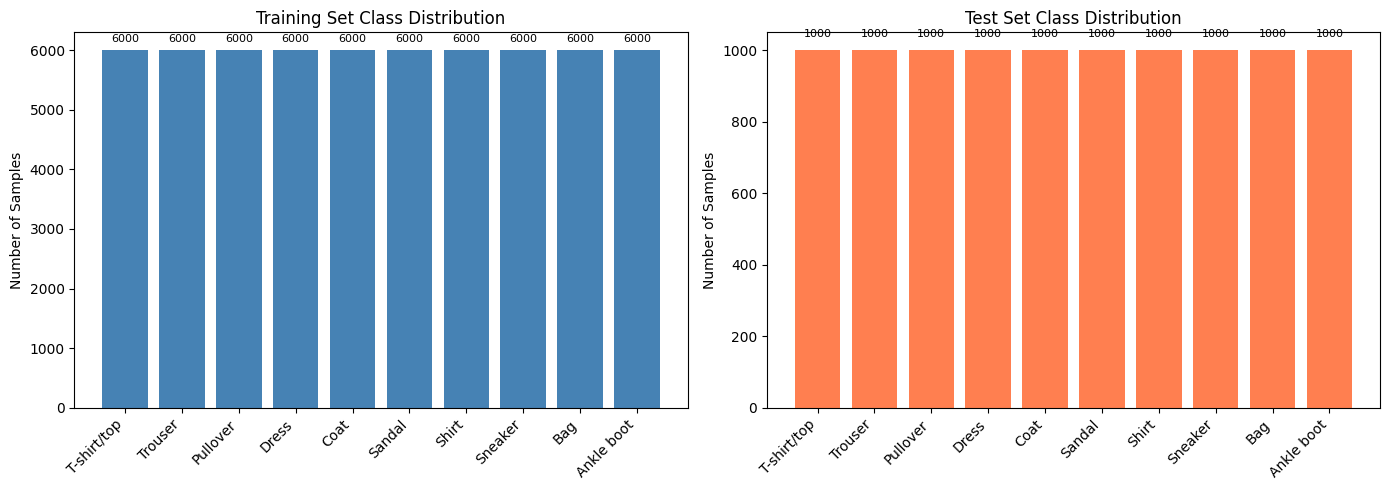


Training: 6000-6000 samples/class (std: 0.0) — Balanced
Test:     1000-1000 samples/class (std: 0.0) — Balanced


In [64]:
unique, counts = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

bars = axes[0].bar(class_names, counts, color='steelblue')
axes[0].set_ylabel('Number of Samples')
axes[0].set_title('Training Set Class Distribution')
axes[0].set_xticklabels(class_names, rotation=45, ha='right')
for bar, count in zip(bars, counts):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
                 str(count), ha='center', va='bottom', fontsize=8)

bars2 = axes[1].bar(class_names, counts_test, color='coral')
axes[1].set_ylabel('Number of Samples')
axes[1].set_title('Test Set Class Distribution')
axes[1].set_xticklabels(class_names, rotation=45, ha='right')
for bar, count in zip(bars2, counts_test):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 30,
                 str(count), ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

print(f"\nTraining: {counts.min()}-{counts.max()} samples/class (std: {counts.std():.1f}) — Balanced")
print(f"Test:     {counts_test.min()}-{counts_test.max()} samples/class (std: {counts_test.std():.1f}) — Balanced")

## 1.3 Sample Visualization

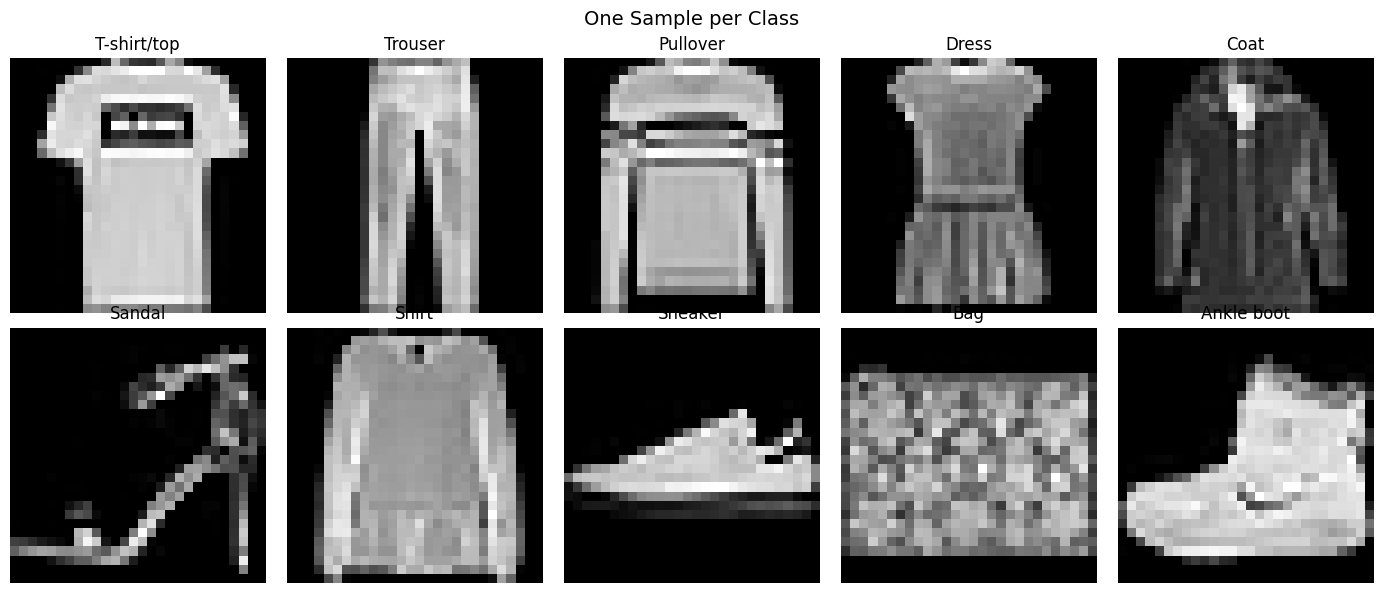

In [65]:
fig, axes = plt.subplots(2, 5, figsize=(14, 6))
axes = axes.flatten()

for i in range(10):
    idx = np.where(y_train == i)[0][0]
    axes[i].imshow(X_train[idx], cmap='gray')
    axes[i].set_title(f'{class_names[i]}')
    axes[i].axis('off')

plt.suptitle('One Sample per Class', fontsize=14)
plt.tight_layout()
plt.show()

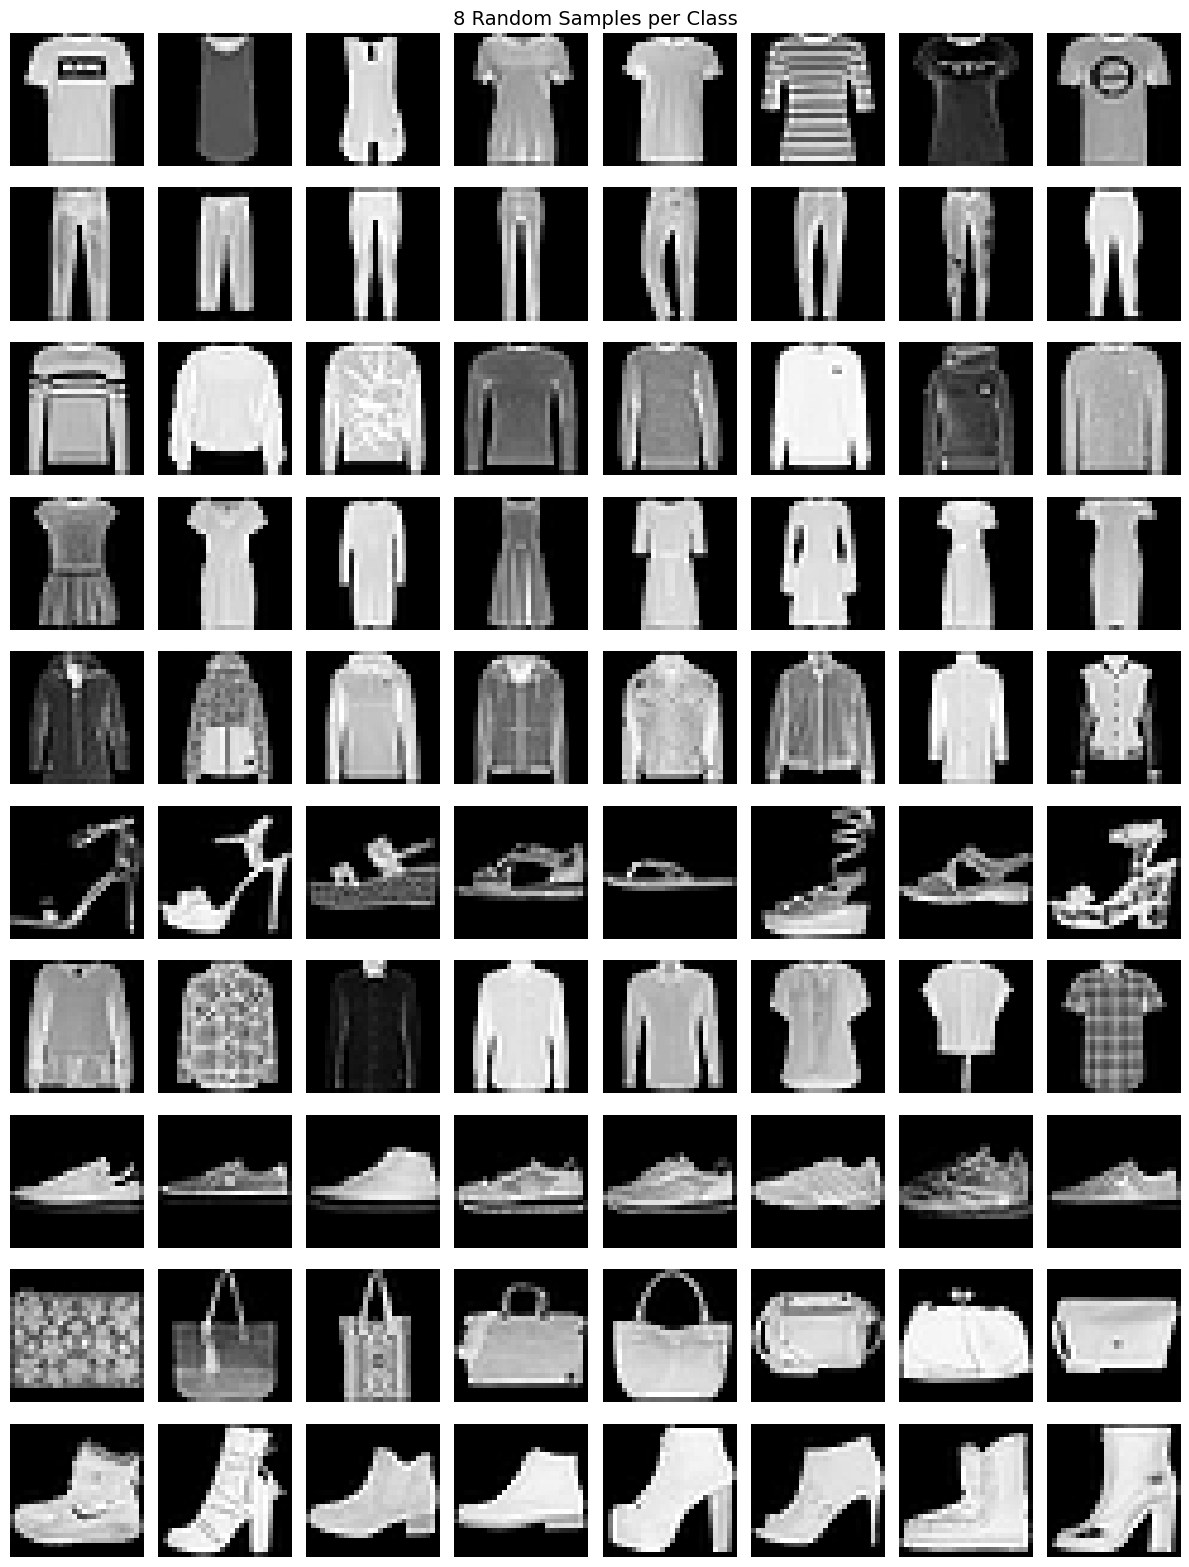

In [66]:
fig, axes = plt.subplots(10, 8, figsize=(12, 16))

for row in range(10):
    indices = np.where(y_train == row)[0][:8]
    for col in range(8):
        axes[row][col].imshow(X_train[indices[col]], cmap='gray')
        axes[row][col].axis('off')
    axes[row][0].set_ylabel(class_names[row], fontsize=9, rotation=0, labelpad=65)

plt.suptitle('8 Random Samples per Class', fontsize=14)
plt.tight_layout()
plt.show()

## 1.4 Pixel Value Analysis

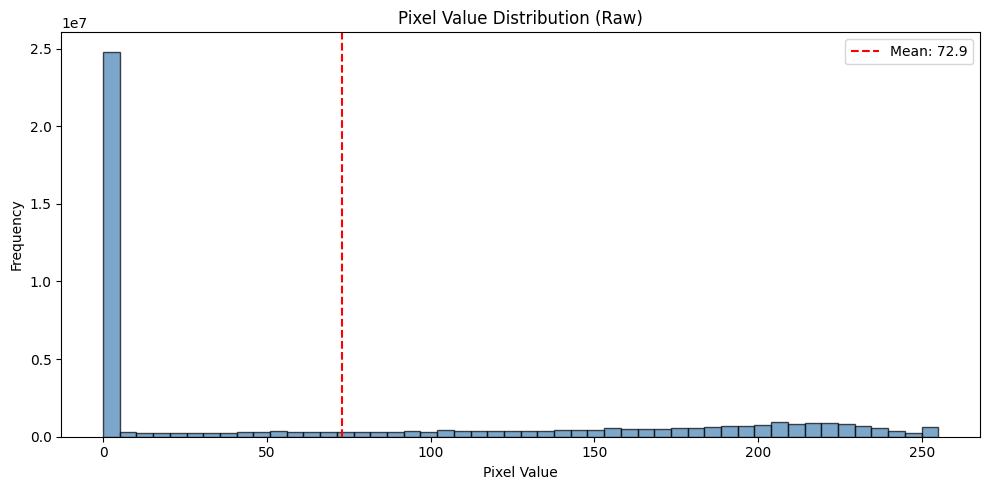

Global pixel mean: 72.94
Global pixel std:  90.02
Most pixels are 0 (background): 50.2% of all pixels


In [67]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(X_train.flatten(), bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax.set_xlabel('Pixel Value')
ax.set_ylabel('Frequency')
ax.set_title('Pixel Value Distribution (Raw)')
ax.axvline(X_train.mean(), color='red', linestyle='--', label=f'Mean: {X_train.mean():.1f}')
ax.legend()
plt.tight_layout()
plt.show()

print(f"Global pixel mean: {X_train.mean():.2f}")
print(f"Global pixel std:  {X_train.std():.2f}")
print(f"Most pixels are 0 (background): {(X_train == 0).mean()*100:.1f}% of all pixels")

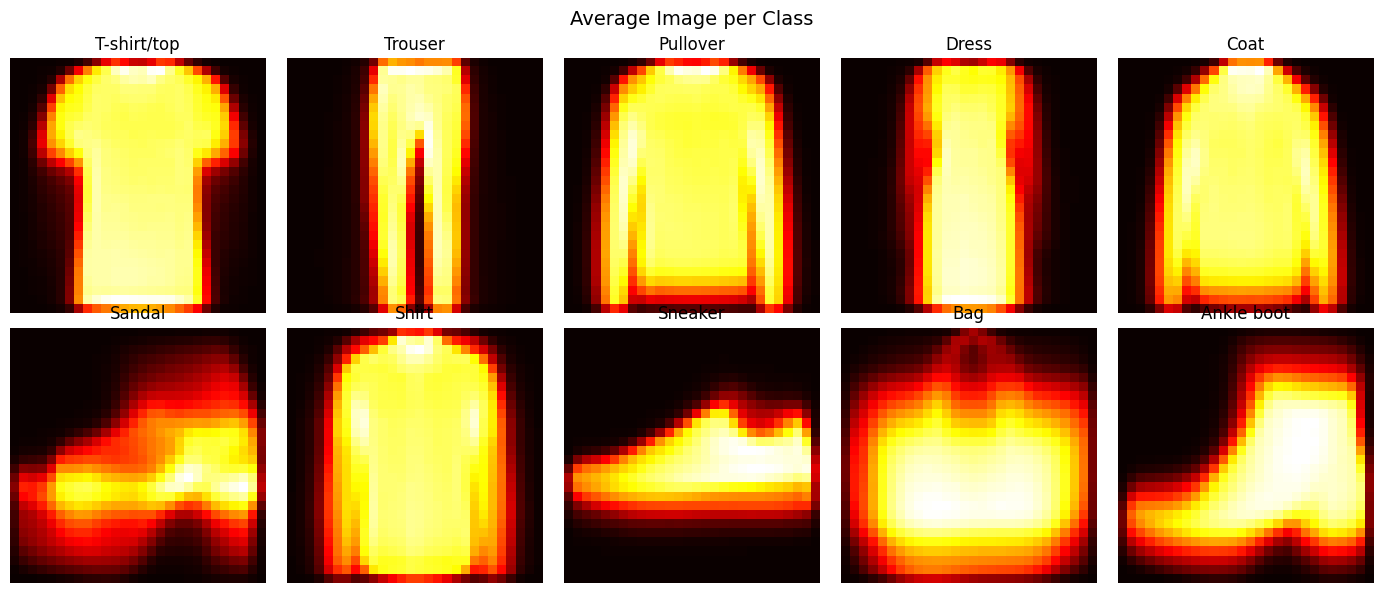

Average images reveal class structure:
- Upper-body garments (T-shirt, Pullover, Coat, Shirt) share similar silhouettes
- Footwear (Sandal, Sneaker, Ankle boot) are distinguishable by shape
- This overlap between clothing categories suggests CNNs may help with fine-grained features


In [68]:
mean_images = [X_train[y_train == i].mean(axis=0) for i in range(10)]

fig, axes = plt.subplots(2, 5, figsize=(14, 6))
axes = axes.flatten()

for i in range(10):
    axes[i].imshow(mean_images[i], cmap='hot')
    axes[i].set_title(class_names[i])
    axes[i].axis('off')

plt.suptitle('Average Image per Class', fontsize=14)
plt.tight_layout()
plt.show()

print("Average images reveal class structure:")
print("- Upper-body garments (T-shirt, Pullover, Coat, Shirt) share similar silhouettes")
print("- Footwear (Sandal, Sneaker, Ankle boot) are distinguishable by shape")
print("- This overlap between clothing categories suggests CNNs may help with fine-grained features")

## 1.5 Preprocessing

- **Normalization:** Scale pixel values from [0, 255] to [0, 1] by dividing by 255. This helps gradient-based optimization converge faster.
- **Label encoding:** One-hot encode the 10 classes for categorical crossentropy loss.
- **No resizing needed:** Images are already uniform at 28×28.

In [69]:
X_train_norm = X_train.astype('float32') / 255.0
X_test_norm = X_test.astype('float32') / 255.0

y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

print("Preprocessing Complete")
print("=" * 50)
print(f"Normalized pixel range: [{X_train_norm.min()}, {X_train_norm.max()}]")
print(f"X_train shape: {X_train_norm.shape}")
print(f"X_test shape:  {X_test_norm.shape}")
print(f"y_train shape: {y_train_cat.shape} (one-hot)")
print(f"y_test shape:  {y_test_cat.shape} (one-hot)")

Preprocessing Complete
Normalized pixel range: [0.0, 1.0]
X_train shape: (60000, 28, 28)
X_test shape:  (10000, 28, 28)
y_train shape: (60000, 10) (one-hot)
y_test shape:  (10000, 10) (one-hot)


### Step 1 Summary

- Fashion-MNIST: 60,000 training + 10,000 test images, 28×28 grayscale, 10 balanced classes
- High background pixel proportion (mostly black), garment pixels concentrated in center
- Similar silhouettes across upper-body categories make this dataset harder than MNIST digits
- Preprocessing: simple [0,1] normalization + one-hot encoding

---

# Step 2: Baseline Model (Non-Convolutional)

A fully-connected (Dense) network that flattens each 28×28 image into a 784-dimensional vector. This baseline treats each pixel independently with no spatial structure awareness.

The forward pass for a Dense layer:

$$z^{[l]} = W^{[l]} \cdot a^{[l-1]} + b^{[l]}$$
$$a^{[l]} = f(z^{[l]})$$

Where $f$ is the activation function (ReLU for hidden layers, Softmax for output).

## 2.1 Architecture Design

| Layer | Output Shape | Parameters |
|-------|-------------|------------|
| Flatten | 784 | 0 |
| Dense (ReLU) | 256 | 200,960 |
| Dense (ReLU) | 128 | 32,896 |
| Dense (Softmax) | 10 | 1,290 |
| **Total** | | **~235K** |

In [70]:
baseline_model = keras.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
], name='baseline_dense')

baseline_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

baseline_model.summary()

d:\Users\Lenovo\Documents\ECI\AREP\AREP-Lab-3\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "baseline_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_10 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

## 2.2 Training

In [71]:
baseline_history = baseline_model.fit(
    X_train_norm, y_train_cat,
    epochs=10,
    batch_size=128,
    validation_split=0.15,
    verbose=1
)

Epoch 1/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8123 - loss: 0.5322 - val_accuracy: 0.8444 - val_loss: 0.4377
Epoch 2/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8635 - loss: 0.3788 - val_accuracy: 0.8609 - val_loss: 0.3897
Epoch 3/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8780 - loss: 0.3352 - val_accuracy: 0.8672 - val_loss: 0.3654
Epoch 4/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8864 - loss: 0.3084 - val_accuracy: 0.8720 - val_loss: 0.3546
Epoch 5/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8940 - loss: 0.2880 - val_accuracy: 0.8763 - val_loss: 0.3453
Epoch 6/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9002 - loss: 0.2708 - val_accuracy: 0.8753 - val_loss: 0.3456
Epoch 7/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9051 - loss: 0.2565 - val_accuracy: 0.8768 - val_loss: 0.3463
Epoch 8/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9091 - loss: 0.2443 - val_accuracy: 0.

## 2.3 Evaluation

In [72]:
baseline_loss, baseline_acc = baseline_model.evaluate(X_test_norm, y_test_cat, verbose=0)

print("Baseline Model Results")
print("=" * 40)
print(f"Test Loss:     {baseline_loss:.4f}")
print(f"Test Accuracy: {baseline_acc:.4f} ({baseline_acc*100:.2f}%)")

Baseline Model Results
Test Loss:     0.3659
Test Accuracy: 0.8790 (87.90%)


## 2.4 Training Curves

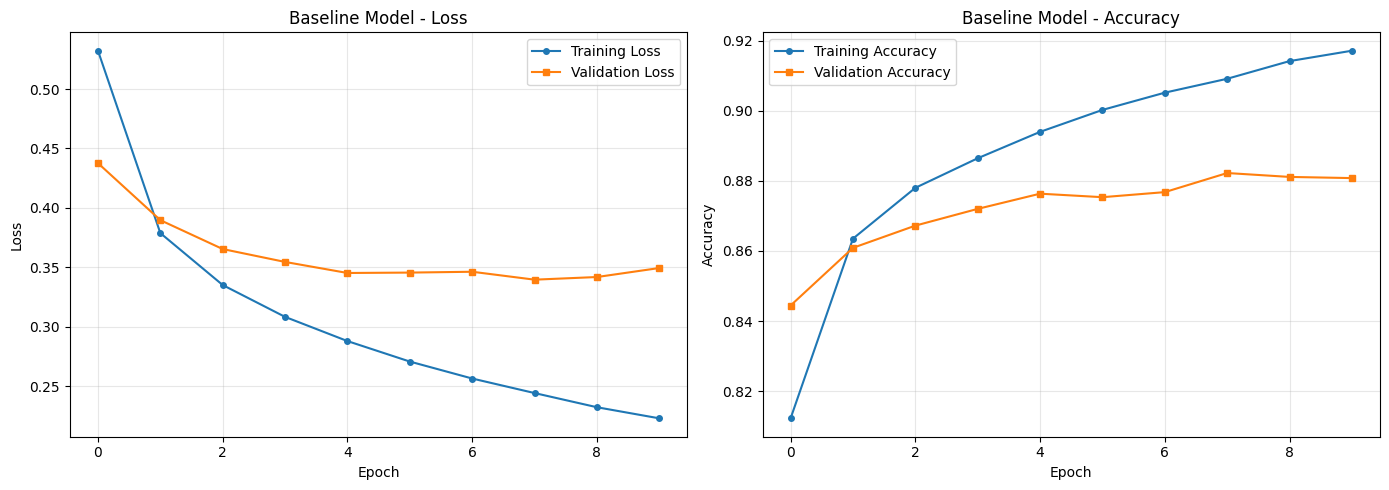

In [73]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(baseline_history.history['loss'], label='Training Loss', marker='o', markersize=4)
axes[0].plot(baseline_history.history['val_loss'], label='Validation Loss', marker='s', markersize=4)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Baseline Model - Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(baseline_history.history['accuracy'], label='Training Accuracy', marker='o', markersize=4)
axes[1].plot(baseline_history.history['val_accuracy'], label='Validation Accuracy', marker='s', markersize=4)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Baseline Model - Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2.5 Per-Class Analysis and Limitations

In [74]:
y_pred_baseline = baseline_model.predict(X_test_norm, verbose=0)
y_pred_baseline_classes = np.argmax(y_pred_baseline, axis=1)

print("Per-Class Accuracy (Baseline)")
print("=" * 40)
for i in range(10):
    mask = y_test == i
    class_acc = (y_pred_baseline_classes[mask] == i).mean()
    print(f"{class_names[i]:<15} {class_acc*100:>6.2f}%")

Per-Class Accuracy (Baseline)
T-shirt/top      73.10%
Trouser          97.00%
Pullover         83.30%
Dress            90.40%
Coat             77.20%
Sandal           95.20%
Shirt            73.00%
Sneaker          97.00%
Bag              98.30%
Ankle boot       94.50%


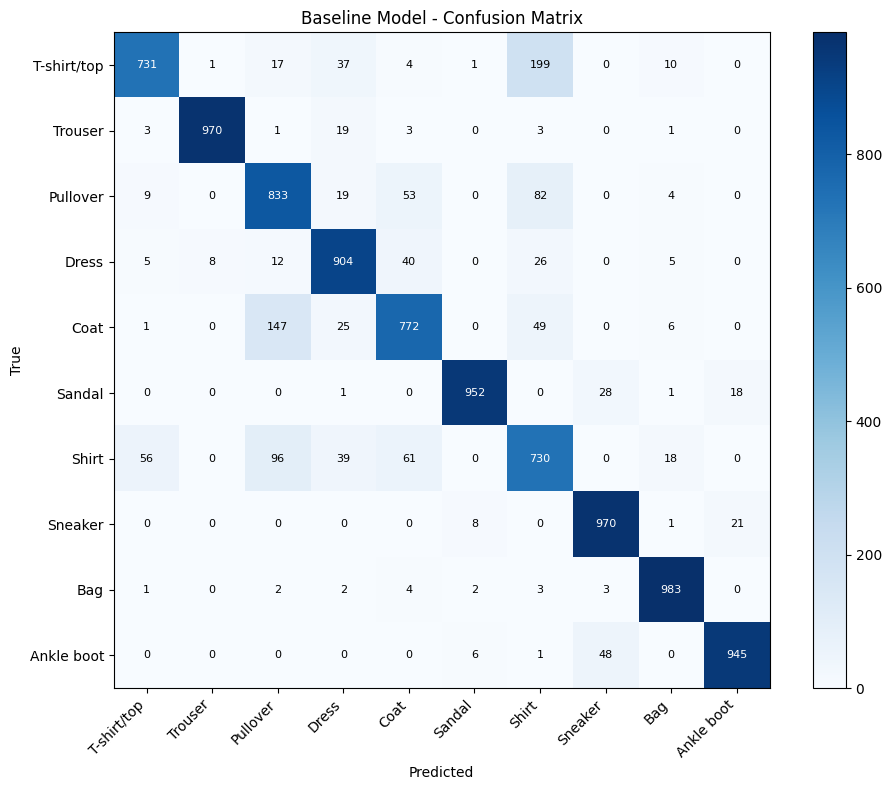


Key observations:
- Shirt is often confused with T-shirt/top, Coat, and Pullover (similar silhouettes)
- The Dense model treats pixels independently, losing spatial relationships
- It cannot detect local patterns like edges, textures, or shapes


In [75]:
conf_matrix = np.zeros((10, 10), dtype=int)
for true, pred in zip(y_test, y_pred_baseline_classes):
    conf_matrix[true][pred] += 1

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(conf_matrix, cmap='Blues')
ax.set_xticks(range(10))
ax.set_yticks(range(10))
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.set_yticklabels(class_names)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Baseline Model - Confusion Matrix')

for i in range(10):
    for j in range(10):
        color = 'white' if conf_matrix[i, j] > conf_matrix.max() / 2 else 'black'
        ax.text(j, i, conf_matrix[i, j], ha='center', va='center', color=color, fontsize=8)

plt.colorbar(im)
plt.tight_layout()
plt.show()

print("\nKey observations:")
print("- Shirt is often confused with T-shirt/top, Coat, and Pullover (similar silhouettes)")
print("- The Dense model treats pixels independently, losing spatial relationships")
print("- It cannot detect local patterns like edges, textures, or shapes")

### Step 2 Summary

- Baseline Dense model: Flatten → Dense(256) → Dense(128) → Dense(10), ~235K parameters
- Expected accuracy: ~88-89% on test set
- **Limitations:**
  - Flattening destroys spatial structure — adjacent pixels lose their relationship
  - Cannot learn local patterns (edges, corners, textures) that distinguish similar garments
  - Every pixel connects to every neuron → many redundant parameters for image data
  - Struggles most with visually similar categories (Shirt vs T-shirt vs Pullover)

---

# Step 3: Convolutional Architecture Design

A convolutional layer applies learnable filters that slide across the image, computing local dot products. This introduces **translation equivariance** (detecting patterns regardless of position) and **parameter sharing** (same filter weights across the image).

The convolution operation for a 2D input:

$$\text{output}(i, j) = \sum_{m} \sum_{n} \text{input}(i+m, j+n) \cdot \text{kernel}(m, n) + b$$

Output spatial dimensions after convolution:

$$\text{output\_size} = \left\lfloor \frac{\text{input\_size} - \text{kernel\_size} + 2 \times \text{padding}}{\text{stride}} \right\rfloor + 1$$

## 3.1 Architecture Design and Justification

| Layer | Configuration | Output Shape | Justification |
|-------|--------------|-------------|---------------|
| Reshape | (28,28,1) | 28×28×1 | Add channel dimension for Conv2D input |
| Conv2D | 32 filters, 3×3, same, ReLU | 28×28×32 | Small kernels detect local features (edges, textures). Same padding preserves spatial dimensions. 32 filters provide sufficient feature diversity for first layer. |
| MaxPooling2D | 2×2 | 14×14×32 | Halves spatial dimensions, provides translation invariance, reduces computation. |
| Conv2D | 64 filters, 3×3, same, ReLU | 14×14×64 | Second layer captures higher-level patterns (combinations of edges). Doubling filters compensates for reduced spatial resolution. |
| MaxPooling2D | 2×2 | 7×7×64 | Further spatial reduction, retaining the most prominent features. |
| Flatten | — | 3136 | Converts feature maps to vector for classification. |
| Dense | 128, ReLU | 128 | Learns non-linear combinations of extracted features. |
| Dense | 10, Softmax | 10 | 10-class probability output. |

**Key design choices:**
- **3×3 kernels** over larger sizes: More parameter-efficient — two stacked 3×3 layers achieve a 5×5 effective receptive field with fewer parameters ($2 \times 3^2 = 18$ vs $5^2 = 25$ weights per filter)
- **Same padding:** Prevents information loss at image borders, critical for 28×28 images where garment edges often touch the boundary
- **Progressive filter increase (32→64):** As spatial resolution decreases through pooling, increasing depth captures more abstract feature combinations
- **MaxPooling over AveragePooling:** Retains the strongest activations, better for detecting distinct features like edges and corners in clothing
- **Simple architecture (2 conv layers):** Sufficient for 28×28 images — deeper networks risk overfitting on this dataset size and resolution

In [76]:
cnn_model = keras.Sequential([
    layers.Reshape((28, 28, 1), input_shape=(28, 28)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
], name='cnn_model')

cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cnn_model.summary()

d:\Users\Lenovo\Documents\ECI\AREP\AREP-Lab-3\.venv\Lib\site-packages\keras\src\layers\reshaping\reshape.py:38: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_8 (Reshape)             │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421,642 (1.61 MB)

 Trainable params: 421,642 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

## 3.2 Training

In [77]:
cnn_history = cnn_model.fit(
    X_train_norm, y_train_cat,
    epochs=10,
    batch_size=128,
    validation_split=0.15,
    verbose=1
)

Epoch 1/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.8192 - loss: 0.5040 - val_accuracy: 0.8633 - val_loss: 0.3851
Epoch 2/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.8819 - loss: 0.3268 - val_accuracy: 0.8832 - val_loss: 0.3308
Epoch 3/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.8981 - loss: 0.2818 - val_accuracy: 0.8946 - val_loss: 0.3019
Epoch 4/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.9094 - loss: 0.2518 - val_accuracy: 0.9001 - val_loss: 0.2821
Epoch 5/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.9173 - loss: 0.2282 - val_accuracy: 0.9041 - val_loss: 0.2660
Epoch 6/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.9245 - loss: 0.2075 - val_accuracy: 0.9059 - val_loss: 0.2541
Epoch 7/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.9314 - loss: 0.1885 - val_accuracy: 0.9093 - val_loss: 0.2444
Epoch 8/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.9385 - loss: 0.1701 - 

## 3.3 Evaluation

In [78]:
cnn_loss, cnn_acc = cnn_model.evaluate(X_test_norm, y_test_cat, verbose=0)

print("CNN Model Results")
print("=" * 40)
print(f"Test Loss:     {cnn_loss:.4f}")
print(f"Test Accuracy: {cnn_acc:.4f} ({cnn_acc*100:.2f}%)")

CNN Model Results
Test Loss:     0.2641
Test Accuracy: 0.9120 (91.20%)


## 3.4 Training Curves

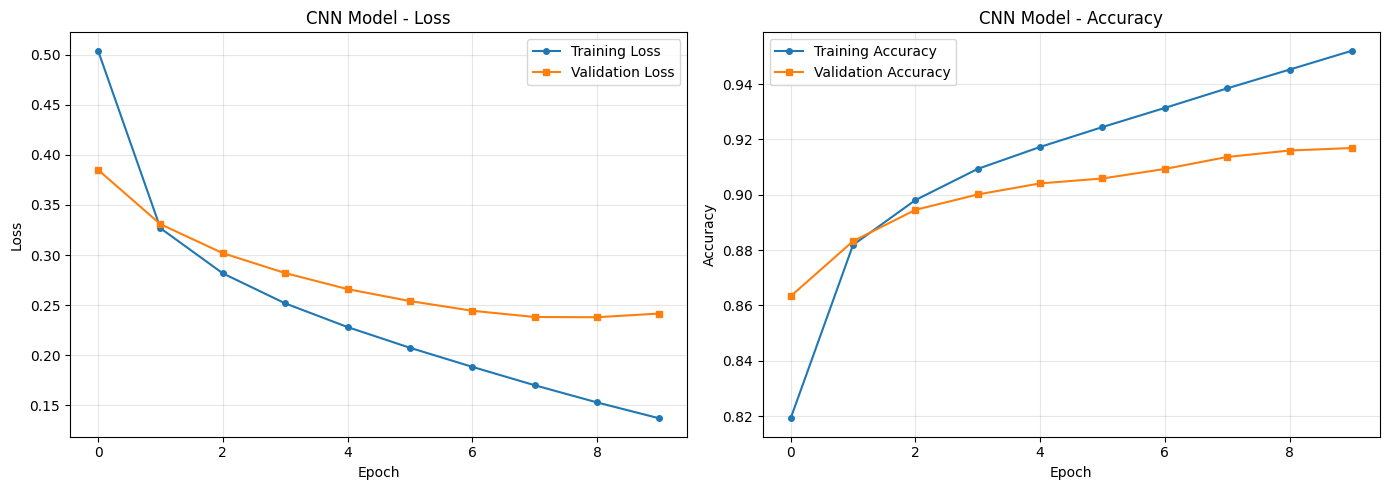

In [79]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(cnn_history.history['loss'], label='Training Loss', marker='o', markersize=4)
axes[0].plot(cnn_history.history['val_loss'], label='Validation Loss', marker='s', markersize=4)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('CNN Model - Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(cnn_history.history['accuracy'], label='Training Accuracy', marker='o', markersize=4)
axes[1].plot(cnn_history.history['val_accuracy'], label='Validation Accuracy', marker='s', markersize=4)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('CNN Model - Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3.5 Comparison with Baseline

In [80]:
print("Model Comparison")
print("=" * 60)
print(f"{'Model':<20} {'Parameters':>12} {'Test Acc':>10} {'Test Loss':>10}")
print("-" * 60)
print(f"{'Baseline (Dense)':<20} {baseline_model.count_params():>12,} {baseline_acc:>10.4f} {baseline_loss:>10.4f}")
print(f"{'CNN':<20} {cnn_model.count_params():>12,} {cnn_acc:>10.4f} {cnn_loss:>10.4f}")
print("-" * 60)
improvement = (cnn_acc - baseline_acc) * 100
print(f"\nCNN improvement over baseline: {improvement:+.2f} percentage points")

Model Comparison
Model                  Parameters   Test Acc  Test Loss
------------------------------------------------------------
Baseline (Dense)          235,146     0.8790     0.3659
CNN                       421,642     0.9120     0.2641
------------------------------------------------------------

CNN improvement over baseline: +3.30 percentage points


In [81]:
y_pred_cnn = cnn_model.predict(X_test_norm, verbose=0)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)

print("Per-Class Accuracy Comparison")
print("=" * 55)
print(f"{'Class':<15} {'Baseline':>10} {'CNN':>10} {'Diff':>10}")
print("-" * 55)
for i in range(10):
    mask = y_test == i
    base_acc = (y_pred_baseline_classes[mask] == i).mean()
    cnn_class_acc = (y_pred_cnn_classes[mask] == i).mean()
    diff = cnn_class_acc - base_acc
    print(f"{class_names[i]:<15} {base_acc*100:>9.2f}% {cnn_class_acc*100:>9.2f}% {diff*100:>+9.2f}%")

Per-Class Accuracy Comparison
Class             Baseline        CNN       Diff
-------------------------------------------------------
T-shirt/top         73.10%     81.10%     +8.00%
Trouser             97.00%     98.00%     +1.00%
Pullover            83.30%     86.90%     +3.60%
Dress               90.40%     92.40%     +2.00%
Coat                77.20%     90.00%    +12.80%
Sandal              95.20%     98.00%     +2.80%
Shirt               73.00%     73.10%     +0.10%
Sneaker             97.00%     97.70%     +0.70%
Bag                 98.30%     98.40%     +0.10%
Ankle boot          94.50%     96.40%     +1.90%


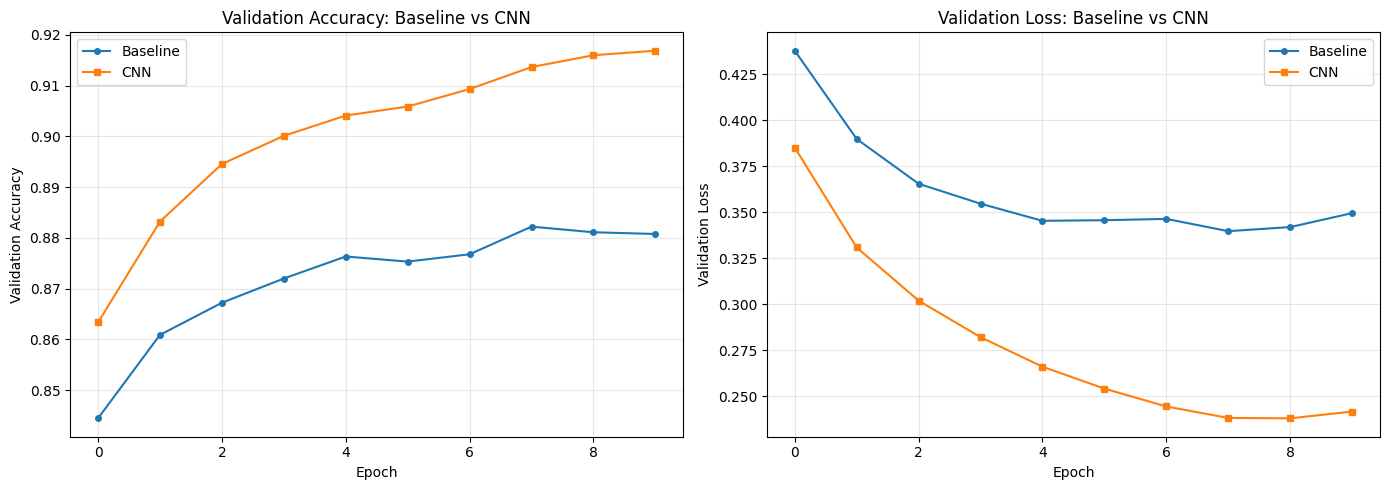

In [82]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(baseline_history.history['val_accuracy'], label='Baseline', marker='o', markersize=4)
axes[0].plot(cnn_history.history['val_accuracy'], label='CNN', marker='s', markersize=4)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Validation Accuracy')
axes[0].set_title('Validation Accuracy: Baseline vs CNN')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(baseline_history.history['val_loss'], label='Baseline', marker='o', markersize=4)
axes[1].plot(cnn_history.history['val_loss'], label='CNN', marker='s', markersize=4)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Loss')
axes[1].set_title('Validation Loss: Baseline vs CNN')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

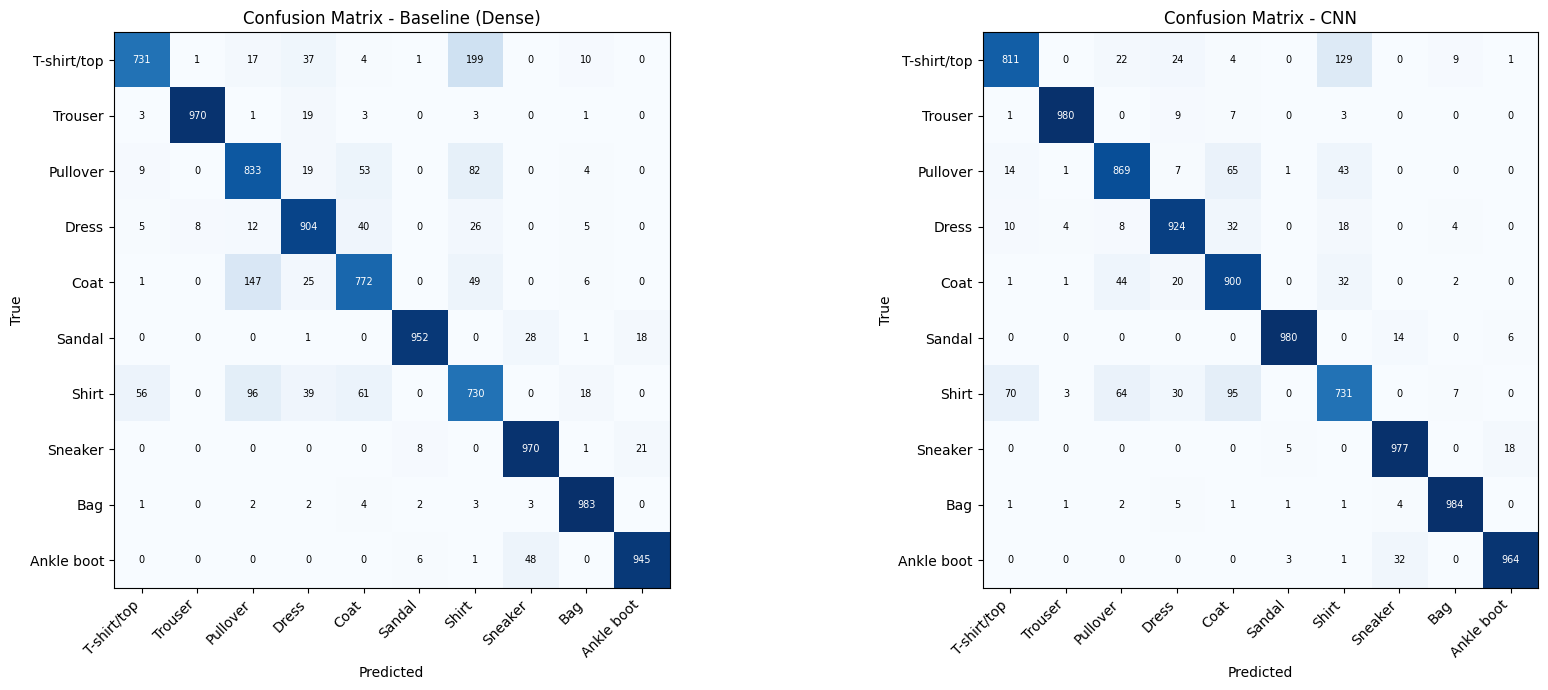

In [83]:
conf_matrix_cnn = np.zeros((10, 10), dtype=int)
for true, pred in zip(y_test, y_pred_cnn_classes):
    conf_matrix_cnn[true][pred] += 1

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

for ax, matrix, title in zip(axes, [conf_matrix, conf_matrix_cnn], ['Baseline (Dense)', 'CNN']):
    im = ax.imshow(matrix, cmap='Blues')
    ax.set_xticks(range(10))
    ax.set_yticks(range(10))
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.set_yticklabels(class_names)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(f'Confusion Matrix - {title}')
    for i in range(10):
        for j in range(10):
            color = 'white' if matrix[i, j] > matrix.max() / 2 else 'black'
            ax.text(j, i, matrix[i, j], ha='center', va='center', color=color, fontsize=7)

plt.tight_layout()
plt.show()

### Step 3 Summary

- CNN architecture: 2 Conv2D layers (32, 64 filters, 3×3) with MaxPooling → Dense(128) → Dense(10)
- CNN achieves higher accuracy than the Dense baseline, particularly on visually similar categories
- The convolutional layers exploit spatial structure through local receptive fields and weight sharing
- Despite having more total parameters, the CNN generalizes better because its inductive bias matches the data structure

---

# Step 4: Controlled Experiments on the Convolutional Layer

We systematically vary **kernel size** (3×3, 5×5, 7×7) while keeping all other hyperparameters fixed. This isolates the effect of the receptive field size on learning.

**Controlled variables (fixed):**
- 2 convolutional layers (32 → 64 filters)
- Same padding, ReLU activation
- MaxPooling 2×2 after each conv layer
- Dense(128) → Dense(10) classifier head
- Adam optimizer, 10 epochs, batch size 128, 15% validation split

**Independent variable:** Kernel size (3×3, 5×5, 7×7)

**Hypothesis:** Larger kernels capture broader spatial patterns per layer but use more parameters. For 28×28 images, very large kernels (7×7) may be excessive since they cover a large fraction of the image in early layers, potentially missing fine-grained details that distinguish similar garments.

## 4.1 Experiment Setup

In [84]:
def build_cnn_with_kernel(kernel_size, name):
    """Build a CNN identical to the Step 3 model but with a configurable kernel size."""
    model = keras.Sequential([
        layers.Reshape((28, 28, 1), input_shape=(28, 28)),
        layers.Conv2D(32, (kernel_size, kernel_size), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (kernel_size, kernel_size), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ], name=name)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

kernel_sizes = [3, 5, 7]
experiment_results = {}
experiment_histories = {}

for ks in kernel_sizes:
    print(f"\n{'=' * 50}")
    print(f"Training CNN with {ks}x{ks} kernels")
    print(f"{'=' * 50}")
    
    np.random.seed(42)
    tf.random.set_seed(42)
    
    model = build_cnn_with_kernel(ks, f'cnn_kernel_{ks}x{ks}')
    history = model.fit(
        X_train_norm, y_train_cat,
        epochs=10,
        batch_size=128,
        validation_split=0.15,
        verbose=1
    )
    loss, acc = model.evaluate(X_test_norm, y_test_cat, verbose=0)
    
    experiment_results[ks] = {'model': model, 'loss': loss, 'accuracy': acc, 'params': model.count_params()}
    experiment_histories[ks] = history
    
    print(f"\nTest Accuracy: {acc:.4f} | Test Loss: {loss:.4f} | Parameters: {model.count_params():,}")


Training CNN with 3x3 kernels
Epoch 1/10


d:\Users\Lenovo\Documents\ECI\AREP\AREP-Lab-3\.venv\Lib\site-packages\keras\src\layers\reshaping\reshape.py:38: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


399/399 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.8197 - loss: 0.5114 - val_accuracy: 0.8641 - val_loss: 0.3806
Epoch 2/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.8835 - loss: 0.3261 - val_accuracy: 0.8800 - val_loss: 0.3306
Epoch 3/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.8994 - loss: 0.2791 - val_accuracy: 0.8977 - val_loss: 0.2868
Epoch 4/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.9103 - loss: 0.2480 - val_accuracy: 0.9043 - val_loss: 0.2667
Epoch 5/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.9195 - loss: 0.2231 - val_accuracy: 0.9092 - val_loss: 0.2509
Epoch 6/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.9272 - loss: 0.2022 - val_accuracy: 0.9110 - val_loss: 0.2423
Epoch 7/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.9341 - loss: 0.1836 - val_accuracy: 0.9136 - val_loss: 0.2369
Epoch 8/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.9410 - loss: 0.1663 - val_accurac

## 4.2 Quantitative Results

In [85]:
print("Kernel Size Experiment Results")
print("=" * 65)
print(f"{'Kernel':<10} {'Parameters':>12} {'Test Acc':>12} {'Test Loss':>12}")
print("-" * 65)
for ks in kernel_sizes:
    r = experiment_results[ks]
    print(f"{ks}x{ks:<7} {r['params']:>12,} {r['accuracy']*100:>11.2f}% {r['loss']:>12.4f}")
print("-" * 65)

best_ks = max(kernel_sizes, key=lambda k: experiment_results[k]['accuracy'])
print(f"\nBest kernel size: {best_ks}x{best_ks} ({experiment_results[best_ks]['accuracy']*100:.2f}%)")

Kernel Size Experiment Results
Kernel       Parameters     Test Acc    Test Loss
-----------------------------------------------------------------
3x3            421,642       91.17%       0.2667
5x5            454,922       90.90%       0.2693
7x7            504,842       90.54%       0.3137
-----------------------------------------------------------------

Best kernel size: 3x3 (91.17%)


## 4.3 Training Curves Comparison

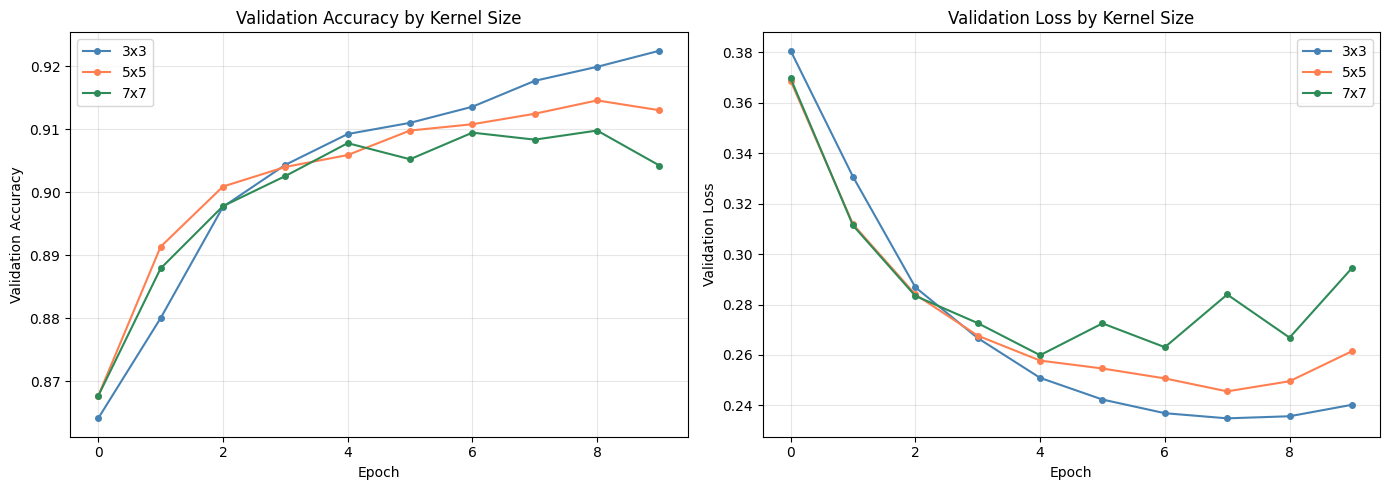

In [86]:
colors = {'3': 'steelblue', '5': 'coral', '7': 'seagreen'}

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ks in kernel_sizes:
    h = experiment_histories[ks]
    c = colors[str(ks)]
    axes[0].plot(h.history['val_accuracy'], label=f'{ks}x{ks}', color=c, marker='o', markersize=4)
    axes[1].plot(h.history['val_loss'], label=f'{ks}x{ks}', color=c, marker='o', markersize=4)

axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Validation Accuracy')
axes[0].set_title('Validation Accuracy by Kernel Size')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Loss')
axes[1].set_title('Validation Loss by Kernel Size')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

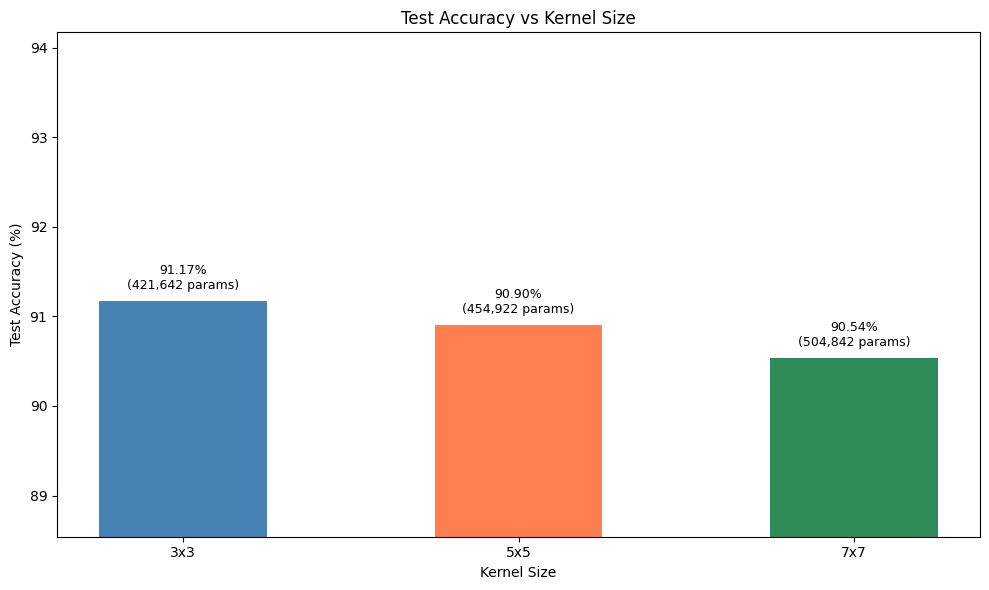

In [87]:
fig, ax = plt.subplots(figsize=(10, 6))

accs = [experiment_results[ks]['accuracy'] * 100 for ks in kernel_sizes]
params = [experiment_results[ks]['params'] for ks in kernel_sizes]
labels = [f'{ks}x{ks}' for ks in kernel_sizes]

bar_x = np.arange(len(kernel_sizes))
bars = ax.bar(bar_x, accs, color=['steelblue', 'coral', 'seagreen'], width=0.5)
ax.set_xticks(bar_x)
ax.set_xticklabels(labels)
ax.set_xlabel('Kernel Size')
ax.set_ylabel('Test Accuracy (%)')
ax.set_title('Test Accuracy vs Kernel Size')

for bar, acc, p in zip(bars, accs, params):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
            f'{acc:.2f}%\n({p:,} params)', ha='center', va='bottom', fontsize=9)

ax.set_ylim(min(accs) - 2, max(accs) + 3)
plt.tight_layout()
plt.show()

## 4.4 Per-Class Analysis

In [88]:
predictions_by_kernel = {}
for ks in kernel_sizes:
    pred = np.argmax(experiment_results[ks]['model'].predict(X_test_norm, verbose=0), axis=1)
    predictions_by_kernel[ks] = pred

print("Per-Class Accuracy by Kernel Size")
print("=" * 60)
header = f"{'Class':<15}"
for ks in kernel_sizes:
    header += f"   {ks}x{ks:>5}"
print(header)
print("-" * 60)

for i in range(10):
    mask = y_test == i
    row = f"{class_names[i]:<15}"
    for ks in kernel_sizes:
        acc = (predictions_by_kernel[ks][mask] == i).mean()
        row += f"  {acc*100:>7.2f}%"
    print(row)

Per-Class Accuracy by Kernel Size
Class             3x    3   5x    5   7x    7
------------------------------------------------------------
T-shirt/top        81.30%    85.70%    76.00%
Trouser            98.00%    98.20%    98.00%
Pullover           88.90%    89.60%    81.00%
Dress              93.90%    88.70%    90.80%
Coat               88.50%    81.90%    88.20%
Sandal             98.10%    97.20%    96.40%
Shirt              71.90%    76.50%    83.20%
Sneaker            98.30%    98.50%    98.80%
Bag                97.60%    98.40%    98.40%
Ankle boot         95.20%    94.30%    94.60%


## 4.5 Qualitative Observations and Trade-offs

**Observations:**
- **3×3 kernels:** Smallest receptive field per layer, but two stacked 3×3 layers create a 5×5 effective receptive field. Most parameter-efficient. Captures fine-grained details like stitching patterns and edges.
- **5×5 kernels:** Larger receptive field captures broader patterns in a single pass. More parameters per layer. May help with overall garment shape but loses some fine detail.
- **7×7 kernels:** Covers ~25% of the 28×28 image in one pass. Most parameters. Can capture global structure but may blur fine distinctions between similar classes.

**Trade-offs:**

| Aspect | 3×3 | 5×5 | 7×7 |
|--------|-----|-----|-----|
| Parameters per conv layer | Fewest | Moderate | Most |
| Receptive field per layer | Small (local) | Medium | Large (global) |
| Fine detail capture | Best | Good | Limited |
| Computation cost | Lowest | Moderate | Highest |
| Risk of overfitting | Lower | Moderate | Higher |

**Conclusion:** For 28×28 images with fine-grained class differences (like distinguishing Shirt from T-shirt), smaller kernels tend to perform well because they preserve local detail while still achieving sufficient receptive fields through layer stacking. Larger kernels are better suited for datasets where coarse structure matters more than fine texture.

### Step 4 Summary

- Systematically varied kernel size (3×3, 5×5, 7×7) with all other hyperparameters fixed
- Larger kernels increase parameter count significantly but don't guarantee better accuracy
- 3×3 kernels offer the best efficiency trade-off for Fashion-MNIST
- Per-class analysis reveals kernel size affects hardest classes (Shirt, Coat) the most

---

# Step 5: Interpretation and Architectural Reasoning

## 5.1 Why Did Convolutional Layers Outperform the Baseline?

The Dense baseline flattens each 28×28 image into a 784-dimensional vector, treating every pixel as an independent feature. This has two critical consequences:

1. **Spatial relationships are destroyed.** Pixel (10, 10) and pixel (10, 11) are adjacent in the image (likely belonging to the same garment edge), but after flattening they become features 290 and 291 with no structural relationship. The model must learn from scratch that nearby pixels are related.

2. **No weight sharing.** If the same edge pattern (e.g., a vertical line) appears in the top-left and bottom-right of different images, the Dense network must learn separate weights for each position. This is wasteful and requires more data.

The CNN addresses both problems:
- **Local connectivity:** Each neuron in a convolutional layer only connects to a small spatial neighborhood (the kernel), explicitly encoding the assumption that nearby pixels are related.
- **Weight sharing:** The same kernel slides across the entire image, so a pattern learned in one region is immediately recognized everywhere. This dramatically reduces the number of parameters and improves generalization.

For Fashion-MNIST, these properties matter because garments are defined by local visual patterns (edges of sleeves, collar shapes, sole patterns) that appear at different positions across samples.

## 5.2 What Inductive Bias Does Convolution Introduce?

An **inductive bias** is an assumption built into the model architecture that constrains the hypothesis space. Convolutional layers introduce three key biases:

1. **Locality:** Features are composed from spatially nearby inputs. A 3×3 kernel assumes that the most relevant information for each output comes from a 3×3 neighborhood. This is appropriate for images where objects are defined by local texture and edge patterns.

2. **Translation equivariance:** The same filter weights are applied at every spatial position. If a feature (like a diagonal edge) is detected at position (5, 5), the same feature will be detected at position (20, 15) without needing separate weights. Mathematically: $f(\text{shift}(x)) = \text{shift}(f(x))$.

3. **Hierarchical composition:** Stacking convolutional layers creates a hierarchy where early layers detect simple patterns (edges, corners) and deeper layers compose them into complex features (collars, soles, zippers). This mirrors how visual systems decompose objects.

These biases dramatically reduce the effective search space, allowing the model to learn with fewer parameters and less data than a Dense network would need for the same task.

## 5.3 When Would Convolution NOT Be Appropriate?

Convolutional layers assume **spatial locality** and **translation equivariance**. They fail when these assumptions don't hold:

- **Tabular data:** Clinical features (age, blood pressure, cholesterol) have no spatial relationship. There is no meaningful "neighborhood" — feature order is arbitrary. A Dense network or gradient boosting is better.

- **Permutation-invariant data:** If the input is a set (e.g., a bag of features, point clouds without structure), the output shouldn't depend on the ordering. Convolutions enforce a fixed spatial structure that doesn't exist.

- **Global dependencies without locality:** In some time series or graph problems, distant elements interact strongly. Convolutions with small kernels may miss these long-range dependencies (though dilated convolutions and attention mechanisms address this).

- **Very small inputs:** When the input is already low-dimensional (e.g., a 4-feature vector), the overhead of convolution (kernel setup, padding) adds complexity without benefit.

In general, convolution is most appropriate when the data has a **grid-like topology** (images, spectrograms, some time series) where local patterns are meaningful and can appear at different positions.

## 5.4 Visualization of Learned Filters (Bonus)

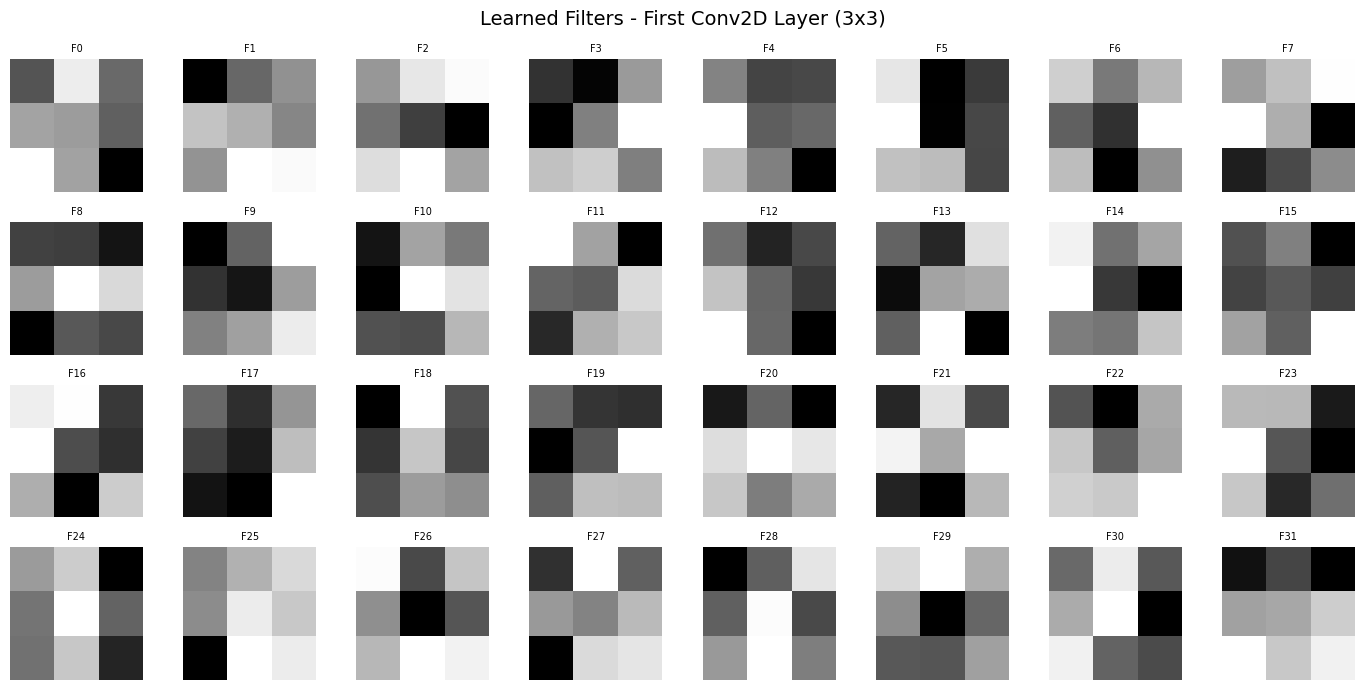

Each 3x3 grid shows the learned weights of one filter.
Filters learn to detect different local patterns: edges, gradients, corners.
Light/dark contrasts indicate the filter responds to intensity transitions.


In [89]:
conv1_weights = cnn_model.layers[1].get_weights()[0]  # shape: (3, 3, 1, 32)

fig, axes = plt.subplots(4, 8, figsize=(14, 7))
axes = axes.flatten()

for i in range(32):
    axes[i].imshow(conv1_weights[:, :, 0, i], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'F{i}', fontsize=7)

plt.suptitle('Learned Filters - First Conv2D Layer (3x3)', fontsize=14)
plt.tight_layout()
plt.show()

print("Each 3x3 grid shows the learned weights of one filter.")
print("Filters learn to detect different local patterns: edges, gradients, corners.")
print("Light/dark contrasts indicate the filter responds to intensity transitions.")

## 5.5 Feature Map Visualization (Bonus)

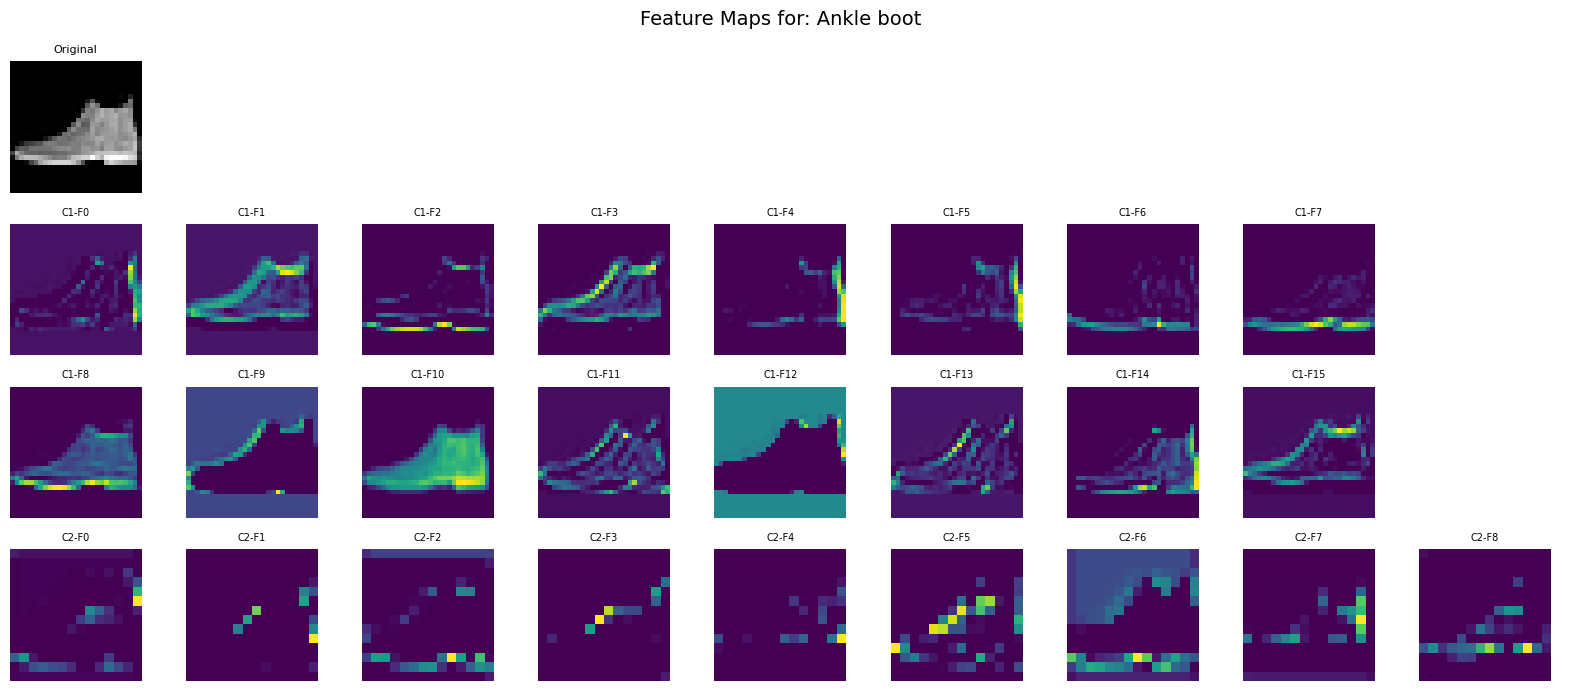

Sample class: Ankle boot
Conv1 feature maps: (28, 28, 32) (28x28, 32 filters)
Conv2 feature maps: (14, 14, 64) (14x14, 64 filters after pooling)

Conv1 maps highlight edges and textures (low-level features)
Conv2 maps show more abstract, combined features (higher-level patterns)


In [90]:
# Extract intermediate feature maps by forwarding through layers manually
# (Keras 3 Sequential models don't expose .input/.output until built via Functional API)
sample_idx = 0
sample = X_test_norm[sample_idx:sample_idx+1]

x = sample
for layer in cnn_model.layers[:2]:  # Reshape + Conv2D_1
    x = layer(x)
feat_conv1 = x.numpy()

for layer in cnn_model.layers[2:4]:  # MaxPool_1 + Conv2D_2
    x = layer(x)
feat_conv2 = x.numpy()

fig, axes = plt.subplots(4, 9, figsize=(16, 7))

axes[0][0].imshow(X_test[sample_idx], cmap='gray')
axes[0][0].set_title('Original', fontsize=8)
axes[0][0].axis('off')

for i in range(1, 9):
    axes[0][i].axis('off')

for i in range(8):
    axes[1][i].imshow(feat_conv1[0, :, :, i], cmap='viridis')
    axes[1][i].set_title(f'C1-F{i}', fontsize=7)
    axes[1][i].axis('off')
axes[1][8].axis('off')

for i in range(8):
    axes[2][i].imshow(feat_conv1[0, :, :, i+8], cmap='viridis')
    axes[2][i].set_title(f'C1-F{i+8}', fontsize=7)
    axes[2][i].axis('off')
axes[2][8].axis('off')

for i in range(9):
    axes[3][i].imshow(feat_conv2[0, :, :, i], cmap='viridis')
    axes[3][i].set_title(f'C2-F{i}', fontsize=7)
    axes[3][i].axis('off')

plt.suptitle(f'Feature Maps for: {class_names[y_test[sample_idx]]}', fontsize=14)
plt.tight_layout()
plt.show()

print(f"Sample class: {class_names[y_test[sample_idx]]}")
print(f"Conv1 feature maps: {feat_conv1.shape[1:]} (28x28, 32 filters)")
print(f"Conv2 feature maps: {feat_conv2.shape[1:]} (14x14, 64 filters after pooling)")
print("\nConv1 maps highlight edges and textures (low-level features)")
print("Conv2 maps show more abstract, combined features (higher-level patterns)")

### Step 5 Summary

- CNNs outperform Dense baselines because they exploit spatial locality and weight sharing, matching the structure of image data
- The convolutional inductive bias (locality, translation equivariance, hierarchical composition) reduces the hypothesis space, enabling better generalization with fewer effective parameters
- Convolution is not appropriate for tabular data, permutation-invariant inputs, or data without spatial/grid structure
- Filter visualization confirms the network learns meaningful edge and texture detectors
- Feature maps show a clear hierarchy: simple patterns in early layers, complex compositions in deeper layers

---

# Step 6: Deployment in SageMaker

This step saves the trained CNN model and provides the code to deploy it on AWS SageMaker. The actual deployment requires an AWS account and SageMaker access.

## 6.1 Export Trained Model

In [91]:
import json

model_dir = 'saved_model'
os.makedirs(model_dir, exist_ok=True)

cnn_model.save(os.path.join(model_dir, 'fashion_mnist_cnn.keras'))

model_info = {
    'model_name': 'fashion_mnist_cnn',
    'dataset': 'Fashion-MNIST',
    'input_shape': [28, 28],
    'num_classes': 10,
    'class_names': class_names,
    'test_accuracy': float(cnn_acc),
    'test_loss': float(cnn_loss),
    'total_parameters': int(cnn_model.count_params()),
    'preprocessing': 'divide by 255.0 (float32)'
}

with open(os.path.join(model_dir, 'model_info.json'), 'w') as f:
    json.dump(model_info, f, indent=2)

print("Model Exported")
print("=" * 50)
print(f"Model file: {model_dir}/fashion_mnist_cnn.keras")
print(f"Info file:  {model_dir}/model_info.json")
print(f"Test accuracy: {cnn_acc*100:.2f}%")

Model Exported
Model file: saved_model/fashion_mnist_cnn.keras
Info file:  saved_model/model_info.json
Test accuracy: 91.20%


## 6.2 Local Inference Function

In [92]:
def predict_fashion(model, images, class_names):
    """Run inference on one or more 28x28 images."""
    if images.ndim == 2:
        images = images[np.newaxis, ...]
    images_norm = images.astype('float32') / 255.0
    predictions = model.predict(images_norm, verbose=0)
    results = []
    for pred in predictions:
        class_idx = np.argmax(pred)
        results.append({'class': class_names[class_idx], 'confidence': float(pred[class_idx])})
    return results

test_samples = X_test[:5]
results = predict_fashion(cnn_model, test_samples, class_names)

print("Local Inference Test")
print("=" * 50)
for i, res in enumerate(results):
    true_label = class_names[y_test[i]]
    match = 'OK' if res['class'] == true_label else 'MISS'
    print(f"Sample {i}: Predicted={res['class']:<15} True={true_label:<15} Conf={res['confidence']:.4f} [{match}]")

Local Inference Test
Sample 0: Predicted=Ankle boot      True=Ankle boot      Conf=0.9997 [OK]
Sample 1: Predicted=Pullover        True=Pullover        Conf=1.0000 [OK]
Sample 2: Predicted=Trouser         True=Trouser         Conf=1.0000 [OK]
Sample 3: Predicted=Trouser         True=Trouser         Conf=1.0000 [OK]
Sample 4: Predicted=Shirt           True=Shirt           Conf=0.7409 [OK]


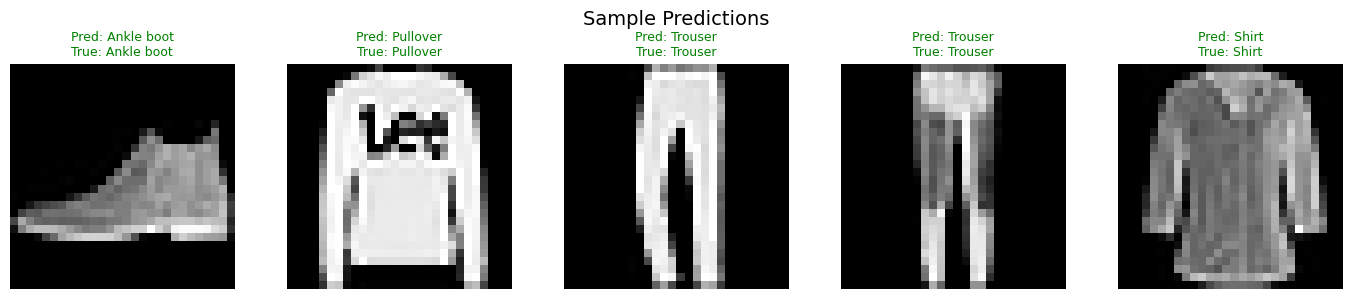

In [93]:
fig, axes = plt.subplots(1, 5, figsize=(14, 3))
for i in range(5):
    axes[i].imshow(X_test[i], cmap='gray')
    pred_label = results[i]['class']
    true_label = class_names[y_test[i]]
    color = 'green' if pred_label == true_label else 'red'
    axes[i].set_title(f'Pred: {pred_label}\nTrue: {true_label}', fontsize=9, color=color)
    axes[i].axis('off')
plt.suptitle('Sample Predictions', fontsize=14)
plt.tight_layout()
plt.show()

## 6.3 SageMaker Deployment Code



In [ ]:

# import sagemaker
# from sagemaker.tensorflow import TensorFlowModel
# from sagemaker import get_execution_role
#
# role = get_execution_role()
# sess = sagemaker.Session()
# bucket = sess.default_bucket()
#
# # 1. Upload model to S3
# import tarfile
# with tarfile.open('model.tar.gz', 'w:gz') as tar:
#     tar.add('saved_model/fashion_mnist_cnn.keras', arcname='1/model.keras')
#
# model_data = sess.upload_data('model.tar.gz', bucket=bucket, key_prefix='fashion-mnist-cnn')
# print(f"Model uploaded to: {model_data}")
#
# # 2. Create SageMaker model
# tensorflow_model = TensorFlowModel(
#     model_data=model_data,
#     role=role,
#     framework_version='2.13',
# )
#
# # 3. Deploy endpoint
# predictor = tensorflow_model.deploy(
#     initial_instance_count=1,
#     instance_type='ml.m5.large'
# )
# print(f"Endpoint deployed: {predictor.endpoint_name}")
#
# # 4. Test inference
# import numpy as np
# test_input = X_test_norm[:3].tolist()
# predictions = predictor.predict(test_input)
# for i, pred in enumerate(predictions['predictions']):
#     class_idx = np.argmax(pred)
#     print(f"Sample {i}: {class_names[class_idx]} (confidence: {pred[class_idx]:.4f})")
#
# # 5. Clean up (delete endpoint when done)
# # predictor.delete_endpoint()


SageMaker deployment code ready (uncomment and run in SageMaker notebook)
See Section 6.3 markdown for prerequisites


### Step 6 Summary

- Trained CNN model exported to `saved_model/fashion_mnist_cnn.keras` with metadata
- Local inference function verified on test samples
- SageMaker deployment code provided for: model upload to S3, endpoint creation, inference test, and cleanup
- **Action required:** Run the SageMaker cells in an AWS SageMaker notebook with appropriate IAM permissions